## Time-series forecasting

Author: Elliot Dahl

Problem statement: Provide a daily forecast for the amount of traffic in a 
particular parking lot for the next month. 

What I have: A time series of number of counted cars in the parking lot extracted from 
images using a computer vision algorithm. 


# Script initialization

In [1]:
#import
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sys, scipy, sklearn
print('Python:  ' + sys.version.split('\n')[0])
print('         ' + sys.version.split('\n')[1])
print('Pandas:  ' + pd.__version__)
print('Numpy:   ' + np.__version__)
print('Scipy:   ' + scipy.__version__)
print('Sklearn: ' + sklearn.__version__)

Python:  3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
         [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas:  0.20.3
Numpy:   1.13.3
Scipy:   0.19.1
Sklearn: 0.19.1


# Load data

In [3]:
ts = pd.read_csv('data.csv') #Read file into a data frame

# Exploring the data set

In [4]:
ts.head()

,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,clear
1,2010-01-02,Saturday,34,0.2,cloudy
2,2010-01-03,Sunday,113,0.4,clear
3,2010-01-04,Monday,5,0.6,cloudy
4,2010-01-05,Tuesday,124,0.1,clear


In [5]:
ts.tail()

,date,day.of.week,car.count,weather,cloud.indicator
2368,2016-06-26,Sunday,102,0.1,clear
2369,2016-06-27,Monday,38,0.6,cloudy
2370,2016-06-28,Tuesday,95,-1.6,clear
2371,2016-06-29,Wednesday,104,-0.1,clear
2372,2016-06-30,Thursday,90,-0.3,cloudy


In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 5 columns):
date               2373 non-null object
day.of.week        2373 non-null object
car.count          2373 non-null int64
weather            2373 non-null float64
cloud.indicator    2373 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 92.8+ KB


In [7]:
# Convert date to datetime object and extract year and month
ts['date'] = pd.to_datetime(ts['date'])
ts['year'] = ts['date'].map(lambda x: x.year)
ts['month'] = ts['date'].map(lambda x: x.month)

In [8]:
ts['date'].value_counts()[:5]

2015-10-18    1
2014-12-12    1
2013-02-01    1
2010-10-21    1
2014-06-29    1
Name: date, dtype: int64

### observation
- Indicates that there is only one feature vector per day

In [9]:
idx = pd.date_range(ts['date'].iloc[0], ts['date'].iloc[-1])
s_check_discontin_dates = ts['car.count'].reindex(idx, fill_value="NaN")
s_check_discontin_dates.isnull().values.any() 

False

### observation
- There are no missing days in the data

In [10]:
ts[['car.count','weather']].describe() #Numerical variables

,car.count,weather
count,2373.000000,2373.000000
mean,112.773704,0.008512
std,50.127710,1.007344
min,0.000000,-3.200000
25%,81.000000,-0.700000
50%,122.000000,0.000000
75%,152.000000,0.700000
max,239.000000,4.300000


In [11]:
#Check if days are correct, should be an equal amount of each
ts['day.of.week'].value_counts()

Thursday     339
Friday       339
Wednesday    339
Sunday       339
Tuesday      339
Saturday     339
Monday       339
Name: day.of.week, dtype: int64

In [12]:
ts[['day.of.week','cloud.indicator']].describe() #Categorical variables

,day.of.week,cloud.indicator
count,2373,2373
unique,7,2
top,Thursday,clear
freq,339,1353


In [13]:
ts['cloud.indicator'].value_counts()

clear     1353
cloudy    1020
Name: cloud.indicator, dtype: int64

### Observations 

I learn:
- There is 1 categorical (**cloud.indicator**) and 2 numerical variables (**car.count** and **weather**)
- 0 <= **car.count** <= 239,  -3.2 <= **weather** <= 4.3 and **cloud.indicator** $\in$ {clear,cloudy}
- There are no missing days where there is not data
- There are 339 weeks of data

To investigate further:
- How are the various variables correlated? 
- What is the difference between estimates for a cloudy days versus clear days (considering this most likely is acquired through satelite imagery)? Should I keep both? 


# Visual data inspection

In [14]:
ts.head()

,date,day.of.week,car.count,weather,cloud.indicator,year,month
0,2010-01-01,Friday,101,0.1,clear,2010,1
1,2010-01-02,Saturday,34,0.2,cloudy,2010,1
2,2010-01-03,Sunday,113,0.4,clear,2010,1
3,2010-01-04,Monday,5,0.6,cloudy,2010,1
4,2010-01-05,Tuesday,124,0.1,clear,2010,1


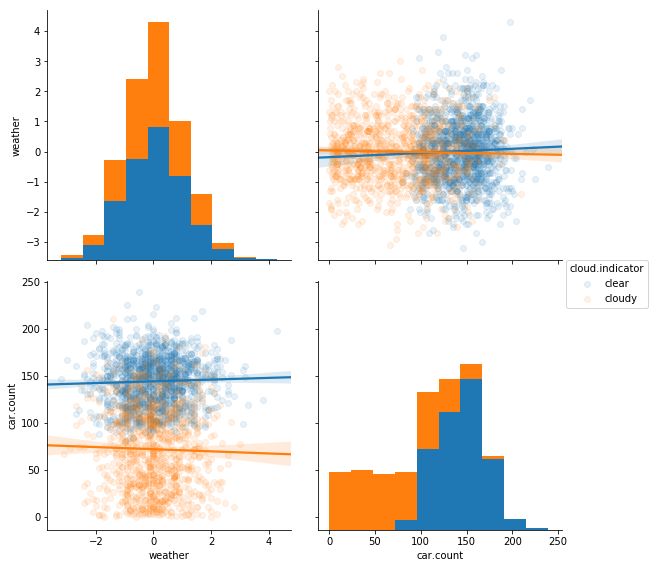

In [15]:
sns.pairplot(data=ts, vars=['weather','car.count'],hue='cloud.indicator', kind='reg', 
             plot_kws={'scatter_kws': {'alpha': 0.1}},size=4)

### Plot observations
- Tells me that **car.count** is not really a function of **weather** neither for cloudy or clear days.
- **car.count** on cloudy days does not appear to be Gaussian distributed, it is also more likely to be fewer **car.counts** when it is cloudy than when it is clear. Most likely this is due to the **car.count** predictive power is less when the imagery is somwhat blurry due to the clouds. 
- **car.count** on clear days seem to be Gaussian distributed, which I would expect.

Next:
- Check if cloudy days **car.count** should be kept.

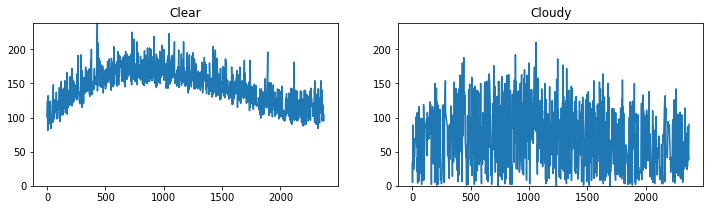

In [16]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(ts[(ts['cloud.indicator']=='clear')]['car.count'])
ax1.set_title('Clear')
ax1.set_ylim([0,239])

ax2.plot(ts[(ts['cloud.indicator']=='cloudy')]['car.count'])
ax2.set_title('Cloudy')
ax2.set_ylim([0,239]);

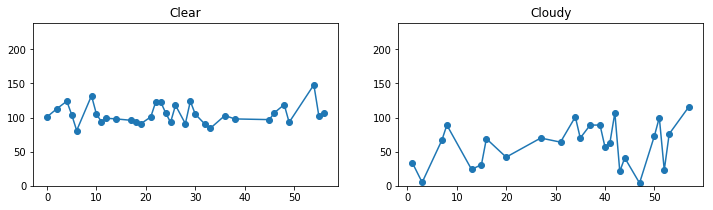

In [17]:
#Smaller interval
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(ts[(ts['cloud.indicator']=='clear') & (ts['date'] < '2010-02-28')]['car.count'],marker='o')
ax1.set_title('Clear')
ax1.set_ylim([0,239])

ax2.plot(ts[(ts['cloud.indicator']=='cloudy') & (ts['date'] < '2010-02-28')]['car.count'],marker='o')
ax2.set_title('Cloudy')
ax2.set_ylim([0,239]);

In [18]:
ts[ts['cloud.indicator']=='clear']['car.count'].describe()

count    1353.000000
mean      143.811530
std        26.038077
min        81.000000
25%       124.000000
50%       146.000000
75%       162.000000
max       239.000000
Name: car.count, dtype: float64

In [19]:
ts[ts['cloud.indicator']=='cloudy']['car.count'].describe()

count    1020.000000
mean       71.602941
std        44.428109
min         0.000000
25%        34.000000
50%        69.000000
75%       106.000000
max       210.000000
Name: car.count, dtype: float64

### Plot observations and describe observation
- cloudy days have consistently fewer **car.count** than clear days and bigger variance. Most likely not a true estimate of the number of cars those specific days. 

Action: Drop cloudy days data and interpolate the clear data to be these missing date values instead. 

## Drop cloudy days data and use clear day data to interpolate the missing ones

In [20]:
ts_clear = ts[ts['cloud.indicator']=='clear'] #Drop cloudy days

In [21]:
ts_clear.head()

,date,day.of.week,car.count,weather,cloud.indicator,year,month
0,2010-01-01,Friday,101,0.1,clear,2010,1
2,2010-01-03,Sunday,113,0.4,clear,2010,1
4,2010-01-05,Tuesday,124,0.1,clear,2010,1
5,2010-01-06,Wednesday,104,-0.1,clear,2010,1
6,2010-01-07,Thursday,81,-1.0,clear,2010,1


In [22]:
#Make a series of the car.count
ts_cc_clear = pd.Series(data=ts_clear['car.count'].values,index=ts_clear['date'])
ts_cc_clear.head()

date
2010-01-01    101
2010-01-03    113
2010-01-05    124
2010-01-06    104
2010-01-07     81
dtype: int64

In [23]:
idx = pd.date_range(ts_cc_clear.index[0], ts_cc_clear.index[-1])
ts_cc_clear_inter = ts_cc_clear.reindex(idx, fill_value="NaN") #Make new series with NaN where there is missing dates
ts_cc_clear_inter.head()

2010-01-01    101
2010-01-02    NaN
2010-01-03    113
2010-01-04    NaN
2010-01-05    124
Freq: D, dtype: object

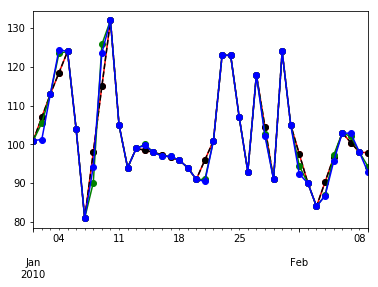

In [24]:
#Check which intepolation scheme that seem to work best
ts_cc_clear_inter.astype(float).interpolate(method='time')[0:40].plot(marker='o',color='r')
ts_cc_clear_inter.astype(float).interpolate(method='linear')[0:40].plot(marker='o',color='k',linestyle='dashed')
ts_cc_clear_inter.astype(float).interpolate(method='spline', order=2)[0:40].plot(marker='o',color='g')
ts_cc_clear_inter.astype(float).interpolate(method='spline', order=3)[0:40].plot(marker='o',color='b')

### Plot observation
- I decide to go with linear/time interpolation, where it is a mean of before and after NaN value. 

In [25]:
ts_cc_clear_inter = ts_cc_clear_inter.astype(float).interpolate(method='linear')
ts_cc_clear_inter.head()

2010-01-01    101.0
2010-01-02    107.0
2010-01-03    113.0
2010-01-04    118.5
2010-01-05    124.0
Freq: D, dtype: float64

In [26]:
ts_cc_clear_inter.isnull().values.any()

False

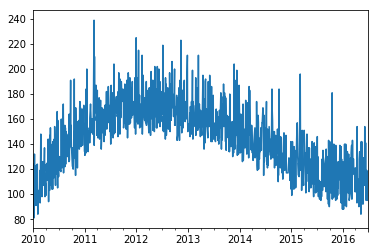

In [27]:
ts_cc_clear_inter.plot()

In [28]:
ts_cc_clear_inter.describe()

count    2372.000000
mean      144.426644
std        25.273126
min        81.000000
25%       125.000000
50%       146.708333
75%       163.000000
max       239.000000
dtype: float64

### observations

- ts is 2373, which is 1 more then ts_cc_clear_inter

In [29]:
ts.head()

,date,day.of.week,car.count,weather,cloud.indicator,year,month
0,2010-01-01,Friday,101,0.1,clear,2010,1
1,2010-01-02,Saturday,34,0.2,cloudy,2010,1
2,2010-01-03,Sunday,113,0.4,clear,2010,1
3,2010-01-04,Monday,5,0.6,cloudy,2010,1
4,2010-01-05,Tuesday,124,0.1,clear,2010,1


In [30]:
ts.tail()

,date,day.of.week,car.count,weather,cloud.indicator,year,month
2368,2016-06-26,Sunday,102,0.1,clear,2016,6
2369,2016-06-27,Monday,38,0.6,cloudy,2016,6
2370,2016-06-28,Tuesday,95,-1.6,clear,2016,6
2371,2016-06-29,Wednesday,104,-0.1,clear,2016,6
2372,2016-06-30,Thursday,90,-0.3,cloudy,2016,6


### observations
- Since the last row is cloudy, it did not get interpolated above. 

Action:
I will drop that one and instead try to forecast that one later on too. 

In [31]:
ts.drop(ts.index[-1],inplace=True);
ts.tail()
print(len(ts))

2372


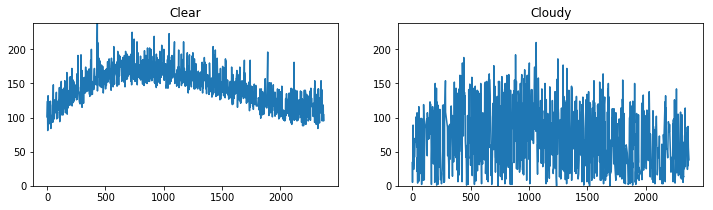

In [32]:
#Before intepolation

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(ts[(ts['cloud.indicator']=='clear')]['car.count'])
ax1.set_title('Clear')
ax1.set_ylim([0,239])

ax2.plot(ts[(ts['cloud.indicator']=='cloudy')]['car.count'])
ax2.set_title('Cloudy')
ax2.set_ylim([0,239]);

In [33]:
ts['car.count'] = ts_cc_clear_inter.values

In [34]:
ts.head()

,date,day.of.week,car.count,weather,cloud.indicator,year,month
0,2010-01-01,Friday,101.0,0.1,clear,2010,1
1,2010-01-02,Saturday,107.0,0.2,cloudy,2010,1
2,2010-01-03,Sunday,113.0,0.4,clear,2010,1
3,2010-01-04,Monday,118.5,0.6,cloudy,2010,1
4,2010-01-05,Tuesday,124.0,0.1,clear,2010,1


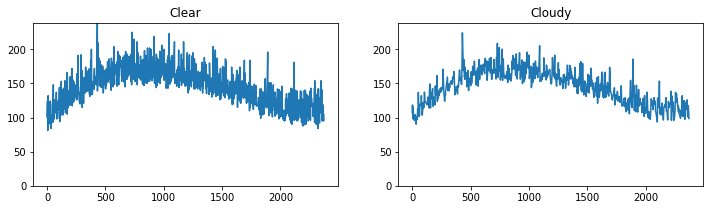

In [35]:
#After intepolation

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(ts[(ts['cloud.indicator']=='clear')]['car.count'])
ax1.set_title('Clear')
ax1.set_ylim([0,239])

ax2.plot(ts[(ts['cloud.indicator']=='cloudy')]['car.count'])
ax2.set_title('Cloudy')
ax2.set_ylim([0,239]);

### Plot observation
- There seem to be less variance for the Cloudy interpolated days then the Clear days now. 

Future action: Look if there is a way to do a better prediction of cloudy days data.

## Visually inspect for recognizable patterns

### Days

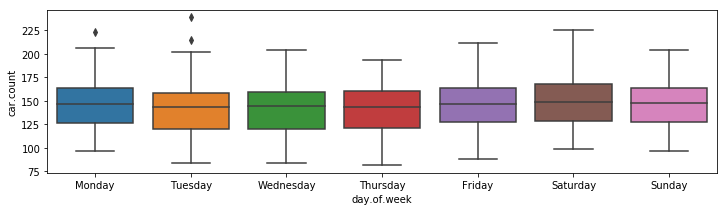

In [36]:
#only clear days
plt.figure(figsize=(12,3))
sns.boxplot(x='day.of.week', y='car.count', data = ts_clear, order=['Monday', 'Tuesday', 'Wednesday', 
            'Thursday', 'Friday', 'Saturday','Sunday'])

In [37]:
ts_clear.groupby('day.of.week').describe()['car.count']

,count,mean,std,min,25%,50%,75%,max
day.of.week,,,,,,,,
Friday,206.0,145.199029,25.835959,88.0,127.25,146.5,163.00,211.0
Monday,195.0,144.984615,25.803675,96.0,126.00,146.0,164.00,223.0
Saturday,197.0,148.411168,26.369983,98.0,128.00,149.0,168.00,225.0
Sunday,189.0,145.576720,24.388929,96.0,127.00,147.0,164.00,204.0
Thursday,184.0,141.250000,25.446236,81.0,121.00,143.0,160.00,193.0
Tuesday,194.0,139.628866,27.737974,84.0,120.00,143.0,157.75,239.0
Wednesday,188.0,141.303191,25.782898,84.0,120.00,144.5,159.25,204.0


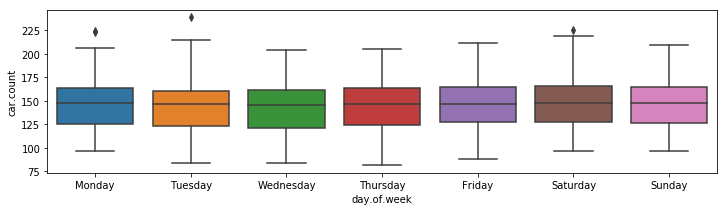

In [38]:
#interpolated data
plt.figure(figsize=(12,3))
sns.boxplot(x='day.of.week', y='car.count', data = ts, order=['Monday', 'Tuesday', 'Wednesday', 
            'Thursday', 'Friday', 'Saturday','Sunday'])

In [39]:
ts.groupby('day.of.week').describe()['car.count']

,count,mean,std,min,25%,50%,75%,max
day.of.week,,,,,,,,
Friday,339.0,145.424566,25.400046,88.000000,127.000,146.000000,164.500000,211.000000
Monday,339.0,145.005086,25.232941,96.000000,125.500,147.000000,163.000000,224.166667
Saturday,339.0,146.446514,25.530608,96.333333,127.000,147.666667,165.100000,225.000000
Sunday,339.0,146.135055,24.757264,96.000000,126.375,147.666667,164.166667,209.333333
Thursday,338.0,143.942188,24.886163,81.000000,124.250,146.500000,163.383333,205.250000
Tuesday,339.0,141.909450,25.839449,84.000000,123.000,146.000000,159.833333,239.000000
Wednesday,339.0,142.122221,25.070541,84.000000,121.000,145.000000,161.000000,204.000000


### observations
- Seem to have lost some of the variation by interpolating. For only clear days there is a larger variation 
in car counts per day then when interpolated data (cloudy days) is included. 

- However, they both agree that Saturday has the most cars and Tuesday has the fewest. 

Future action: look if there is a better way to predict cloudy days car count data. 

### Month

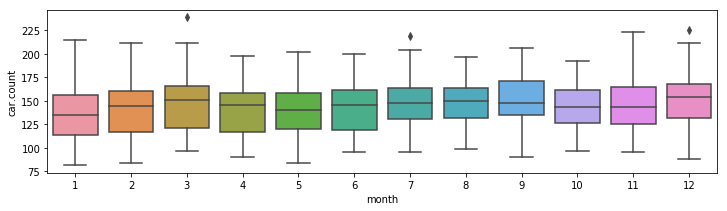

In [40]:
#only clear days
plt.figure(figsize=(12,3))
sns.boxplot(x='month', y='car.count', data=ts_clear)

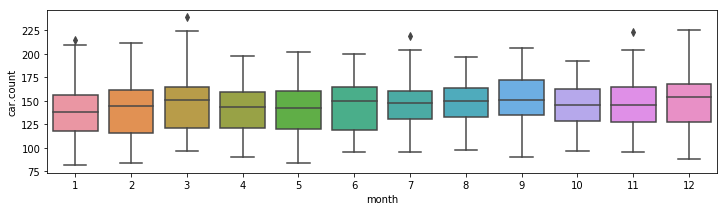

In [41]:
#interpolated data
plt.figure(figsize=(12,3))
sns.boxplot(x='month', y='car.count', data=ts)

In [42]:
#clear
ts_clear.groupby('month').describe()['car.count']

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,140.0,135.378571,26.899886,81.0,113.00,135.0,156.00,215.0
2,93.0,140.763441,27.101820,84.0,117.00,144.0,160.00,211.0
3,111.0,147.684685,28.543741,96.0,121.00,151.0,166.00,239.0
4,115.0,139.365217,25.603019,90.0,117.00,145.0,158.50,198.0
5,136.0,140.110294,25.476110,84.0,120.00,140.5,158.00,202.0
6,124.0,142.991935,25.437791,95.0,119.00,145.5,161.50,200.0
7,97.0,145.546392,25.260732,95.0,130.00,147.0,163.00,219.0
8,101.0,148.019802,21.800908,98.0,131.00,150.0,164.00,197.0
9,109.0,150.752294,23.995430,90.0,135.00,148.0,171.00,206.0


In [43]:
#interpolated
ts.groupby('month').describe()['car.count']

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,217.0,137.884079,26.829724,81.0,118.0000,138.000000,156.000000,215.0
2,198.0,140.193543,27.229267,84.0,116.0000,144.285714,161.000000,211.0
3,217.0,146.598387,27.032490,96.0,121.0000,151.000000,165.000000,239.0
4,210.0,140.066190,23.564479,90.0,121.0000,143.166667,158.750000,198.0
5,217.0,141.561060,25.104785,84.0,120.0000,142.000000,160.000000,202.0
6,209.0,144.333732,25.298040,95.0,119.0000,149.333333,164.500000,200.0
7,186.0,144.185185,24.052234,95.0,130.0000,147.000000,159.833333,219.0
8,186.0,148.551374,20.996320,97.5,132.3125,150.000000,164.000000,197.0
9,180.0,151.870000,23.975003,90.0,134.6250,151.000000,172.083333,206.0


### observations
- Both clear and interpolated data agree that September has the most cars followed closely by December. 
- January is a low month for car counts. 

### Years

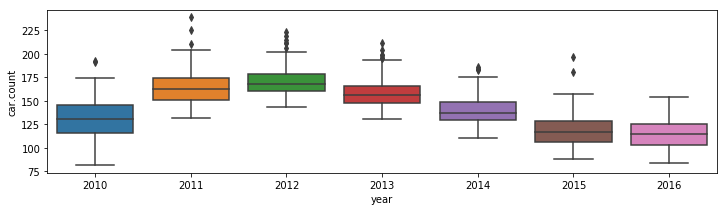

In [44]:
#clear data
plt.figure(figsize=(12,3))
sns.boxplot(x='year', y='car.count', data=ts_clear)

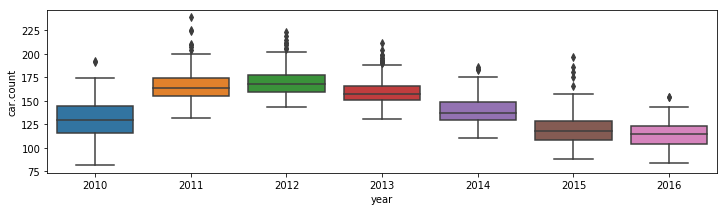

In [45]:
#interpolated
plt.figure(figsize=(12,3))
sns.boxplot(x='year', y='car.count', data=ts)

In [46]:
#clear
ts_clear.groupby('year').describe()['car.count']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2010,226.0,130.035398,20.950706,81.0,115.25,130.0,145.0,192.0
2011,197.0,164.126904,16.714565,131.0,151.00,162.0,174.0,239.0
2012,215.0,169.893023,14.556134,143.0,160.00,168.0,178.0,223.0
2013,195.0,158.625641,15.326628,130.0,147.00,156.0,166.0,211.0
2014,198.0,139.782828,15.348351,110.0,129.00,137.0,149.0,186.0
2015,209.0,118.617225,16.064380,88.0,106.00,117.0,128.0,196.0
2016,113.0,114.415929,15.045007,84.0,103.00,114.0,125.0,154.0


In [47]:
#interpolated
ts.groupby('year').describe()['car.count']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2010,365.0,129.201370,20.076254,81.0,116.000000,129.000000,144.000,192.0
2011,365.0,164.819178,15.550793,131.0,154.500000,164.000000,174.000,239.0
2012,366.0,169.532787,14.040771,143.0,159.500000,167.666667,177.375,223.0
2013,365.0,158.904795,13.399177,130.0,150.500000,157.000000,166.000,211.0
2014,365.0,139.433105,14.304649,110.0,129.250000,137.166667,148.250,186.0
2015,365.0,119.519635,15.767198,88.0,108.500000,118.000000,128.000,196.0
2016,181.0,114.339779,13.829961,84.0,103.333333,114.000000,123.000,154.0


### Plot observations
- There are a couple of outliers in the data. I will keep them for now but might want to investigate them in the future. 
- There is slightly more cars on weekends, less cars in the middle of the week. 
- There seem to be a weak sinuisodal trend in amounts of cars throughout the year (month plot).
- There is an increasing trend between 2010-2012 then the amount of cars decreseas between 2012-2016 and reaches approx the 2010 value again.

Action: Try to remove trends and seasonal effects.

# Attempt to make the count.cars stationary

In [48]:
from statsmodels.tsa.stattools import adfuller;

/Users/elliotdahl/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Augmented Dickey–Fuller test has the null hypothesis that the data is non stationary. 

In [49]:
result = adfuller(ts_cc_clear_inter)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.864692
p-value: 0.348849
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### observations
- The data is non stationary according to the p-value, but this I already knew looking at 
both the trend above and some of the seasonal effects. Shows that Dickey–Fuller test works for this data set. 

### The data is clearly not stationary, has a huge trend in it and some seasonal effects

### Trend

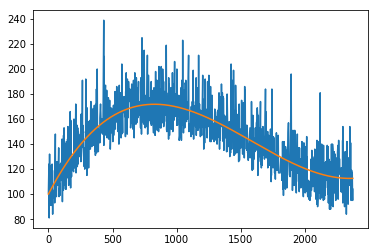

In [50]:
#Find trend
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3

xdata = np.arange(0,len(ts_cc_clear_inter))
popt, pcov = curve_fit(func, xdata, ts_cc_clear_inter.values)
background_trend = func(xdata, *popt)

plt.figure()
plt.plot(xdata,ts_cc_clear_inter)
plt.plot(xdata, background_trend)

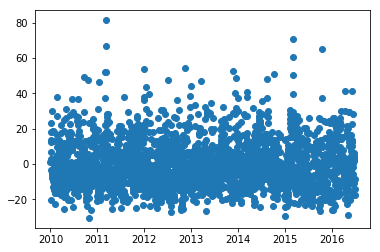

In [51]:
ts_cc_clear_inter_b = ts_cc_clear_inter-background_trend

plt.figure()
plt.plot((ts_cc_clear_inter_b),'o')

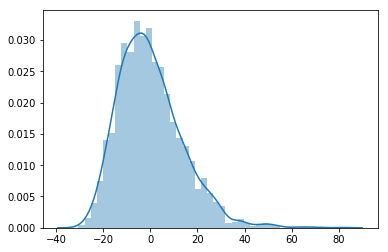

In [52]:
sns.distplot(ts_cc_clear_inter_b)

In [53]:
ts_cc_clear_inter_b.mean()

2.588241864863733e-07

### Plot observation
- The possible outliers seem to have made the distribution plot a little bit non-symmetric. Right tail due to outliers.  

Future action: Look if the predictions would be better without the outliers?  

In [54]:
ts['car_count_no_trend'] = ts_cc_clear_inter_b.values

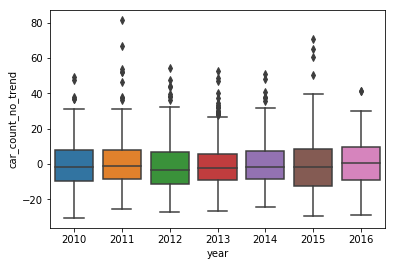

In [55]:
sns.boxplot(x='year', y='car_count_no_trend', data=ts)

## Removing the seasonal effects

## Day of the week effect

In [56]:
ts.head()

,date,day.of.week,car.count,weather,cloud.indicator,year,month,car_count_no_trend
0,2010-01-01,Friday,101.0,0.1,clear,2010,1,0.903291
1,2010-01-02,Saturday,107.0,0.2,cloudy,2010,1,6.706722
2,2010-01-03,Sunday,113.0,0.4,clear,2010,1,12.510474
3,2010-01-04,Monday,118.5,0.6,cloudy,2010,1,17.814548
4,2010-01-05,Tuesday,124.0,0.1,clear,2010,1,23.118943


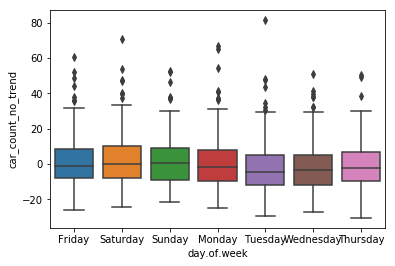

In [57]:
sns.boxplot(x='day.of.week', y='car_count_no_trend', data=ts)

In [58]:
ts.groupby('day.of.week').describe()['car_count_no_trend']

,count,mean,std,min,25%,50%,75%,max
day.of.week,,,,,,,,
Friday,339.0,1.027497,13.779961,-26.145023,-7.865115,-1.291928,8.349550,60.379980
Monday,339.0,0.591678,14.380959,-25.189361,-9.687552,-1.830016,7.977419,66.545547
Saturday,339.0,2.043918,13.753488,-24.524510,-8.006579,-0.106017,9.880302,70.679105
Sunday,339.0,1.727012,13.174378,-21.818747,-8.949911,0.763759,9.264246,52.391966
Thursday,338.0,-0.580903,12.744600,-30.543901,-9.585159,-2.143645,6.759554,50.080795
Tuesday,339.0,-2.509242,14.052939,-29.370604,-12.152453,-4.714664,4.841346,81.301918
Wednesday,339.0,-2.301673,13.170313,-26.969996,-12.111935,-3.537755,4.989990,50.732904


In [59]:
week_day_mean = ts.groupby('day.of.week').mean()['car_count_no_trend']

In [60]:
#Remove weekday mean
week_day_mean = ts.groupby('day.of.week').mean()['car_count_no_trend']

def week_season_func(row):
    return row['car_count_no_trend']-week_day_mean[row['day.of.week']]

ts['car_count_no_trend_day'] = ts.apply(week_season_func, axis=1)

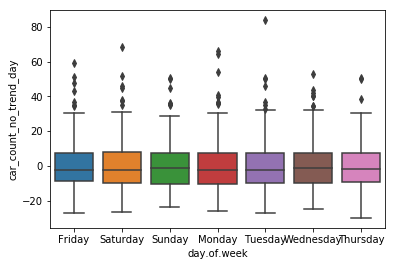

In [61]:
sns.boxplot(x='day.of.week', y='car_count_no_trend_day', data=ts)

In [62]:
ts.groupby('day.of.week').describe()['car_count_no_trend_day']

,count,mean,std,min,25%,50%,75%,max
day.of.week,,,,,,,,
Friday,339.0,-5.449590e-16,13.779961,-27.172520,-8.892612,-2.319426,7.322052,59.352483
Monday,339.0,-3.196394e-16,14.380959,-25.781040,-10.279230,-2.421694,7.385741,65.953869
Saturday,339.0,-2.344896e-16,13.753488,-26.568428,-10.050496,-2.149934,7.836385,68.635187
Sunday,339.0,1.959757e-15,13.174378,-23.545760,-10.676923,-0.963253,7.537234,50.664953
Thursday,338.0,-1.248180e-16,12.744600,-29.962999,-9.004257,-1.562742,7.340456,50.661697
Tuesday,339.0,-3.463634e-15,14.052939,-26.861363,-9.643211,-2.205423,7.350588,83.811160
Wednesday,339.0,-3.274994e-16,13.170313,-24.668322,-9.810261,-1.236081,7.291663,53.034578


### Observation
- The weekly effect seems to be removed. 

Note: I first tried a sinusiodal function with weekly period but it did not do very well in removing the weekly effect. 

## Month effect

In [63]:
ts.head()

,date,day.of.week,car.count,weather,cloud.indicator,year,month,car_count_no_trend,car_count_no_trend_day
0,2010-01-01,Friday,101.0,0.1,clear,2010,1,0.903291,-0.124206
1,2010-01-02,Saturday,107.0,0.2,cloudy,2010,1,6.706722,4.662804
2,2010-01-03,Sunday,113.0,0.4,clear,2010,1,12.510474,10.783462
3,2010-01-04,Monday,118.5,0.6,cloudy,2010,1,17.814548,17.222870
4,2010-01-05,Tuesday,124.0,0.1,clear,2010,1,23.118943,25.628185


In [64]:
ts.groupby('month').describe()['car_count_no_trend_day']

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,217.0,-2.815032,13.618542,-27.172520,-12.426325,-6.119540,5.375284,46.177763
2,198.0,-0.975749,12.445392,-24.214640,-10.016144,-3.957090,6.143212,40.045525
3,217.0,5.024527,16.965949,-23.872170,-7.319513,2.794829,13.948362,83.811160
4,210.0,-1.885498,12.123545,-25.842854,-10.415480,-3.411893,5.077445,43.524834
5,217.0,-0.704176,12.114099,-26.113646,-9.144234,-2.091323,5.944960,32.867401
6,209.0,1.732474,13.049800,-26.568428,-7.740455,-0.102179,10.111872,40.830639
7,186.0,-3.411254,13.164203,-25.781040,-13.377981,-5.063703,3.382273,45.725839
8,186.0,0.823024,12.561788,-23.424354,-6.933403,-0.381034,8.601114,50.402304
9,180.0,4.194198,11.678770,-24.307543,-2.926254,4.114109,11.042892,50.023656


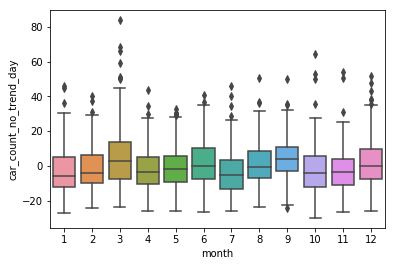

In [65]:
sns.boxplot(x='month', y='car_count_no_trend_day', data=ts)

In [66]:
month_mean = ts.groupby('month').mean()['car_count_no_trend_day']

def month_season_func(row):
    return row['car_count_no_trend_day']-month_mean[row['month']]

ts['car_count_no_trend_day_month'] = ts.apply(month_season_func, axis=1)

In [67]:
ts.groupby('month').describe()['car_count_no_trend_day_month']

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,217.0,-8.677135e-16,13.618542,-24.357488,-9.611293,-3.304509,8.190315,48.992795
2,198.0,1.345725e-17,12.445392,-23.238891,-9.040396,-2.981341,7.118960,41.021273
3,217.0,-9.413873e-17,16.965949,-28.896697,-12.344040,-2.229698,8.923835,78.786633
4,210.0,-1.015061e-15,12.123545,-23.957357,-8.529982,-1.526395,6.962943,45.410331
5,217.0,-2.455793e-16,12.114099,-25.409470,-8.440058,-1.387147,6.649136,33.571576
6,209.0,2.490299e-15,13.049800,-28.300902,-9.472929,-1.834653,8.379398,39.098165
7,186.0,-3.438110e-16,13.164203,-22.369785,-9.966726,-1.652448,6.793528,49.137093
8,186.0,-6.207699e-17,12.561788,-24.247378,-7.756427,-1.204058,7.778091,49.579281
9,180.0,-1.855306e-15,11.678770,-28.501741,-7.120452,-0.080088,6.848694,45.829459


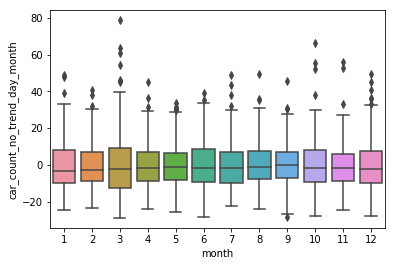

In [68]:
sns.boxplot(x='month', y='car_count_no_trend_day_month', data=ts)

### Observations:
- The monthly effect seem to have been succesfully removed. 

In [69]:
ts_stat = pd.Series(data=ts['car_count_no_trend_day_month'].values, index=ts['date'])

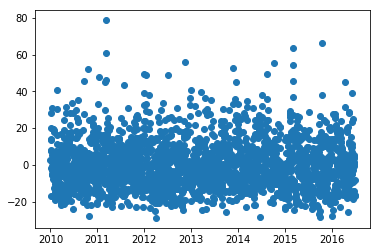

In [70]:
plt.figure()
plt.plot((ts_stat),'o')

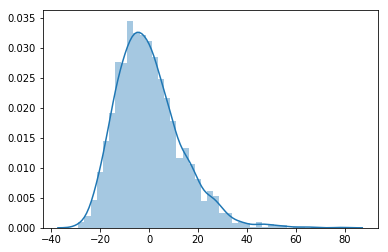

In [71]:
sns.distplot(ts_stat)

### Plot observation 
- Still some effects from the outliers but I will continue with what I have. 

### Stationary test

In [72]:
result = adfuller(ts_stat)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -28.818048
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### observation:
- The null hypothesis is rejected. The data appears to be stationary according to the test above. 

# Explore which forecast model should be used

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

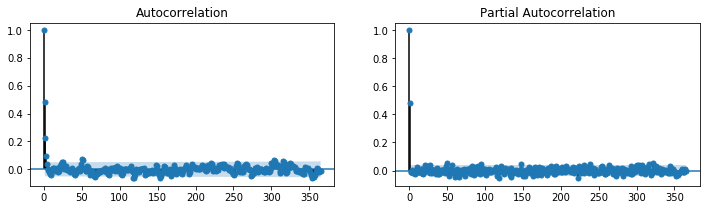

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

plot_acf(ts_stat, lags=365, ax=axes[0].axes);
plot_pacf(ts_stat, lags=365, ax=axes[1].axes);

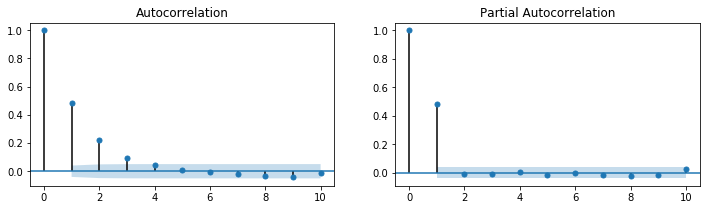

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

plot_acf(ts_stat, lags=10, ax=axes[0].axes);
plot_pacf(ts_stat, lags=10, ax=axes[1].axes);

### Plot observation:
- The PACF curve has a cutoff after lag 1 which means this is most likely a AR(1) process. 
- The ACF shows smooth transition which usually indicates an AR process with no MA components. 

Use a ARIMA process

In [76]:
from statsmodels.tsa.arima_model import ARIMA

# Forecast

### Fit a AR(1) process

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2372
Model:                     ARMA(1, 0)   Log Likelihood               -9192.540
Method:                       css-mle   S.D. of innovations             11.663
Date:                Mon, 30 Apr 2018   AIC                          18391.080
Time:                        15:30:48   BIC                          18408.394
Sample:                    01-01-2010   HQIC                         18397.382
                         - 06-29-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.461     -0.005      0.996      -0.905       0.901
ar.L1.y        0.4806      0.018     26.701      0.000       0.445       0.516
                                    Roots           

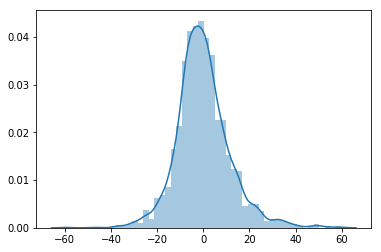

In [77]:
model = ARIMA(ts_stat, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
sns.distplot(model_fit.resid)
print("The residual errors have:")
print(model_fit.resid.describe())

### Observation
- When playing around with p and q in the ARMA process I do not decrease neither AIC nor BIC which indicates that 
AR(1) is for now my first choice. Could have done a grid search too but did not feel necessary. 
- The residuals seem to be Gaussian distributed with zero mean which is what I want. 

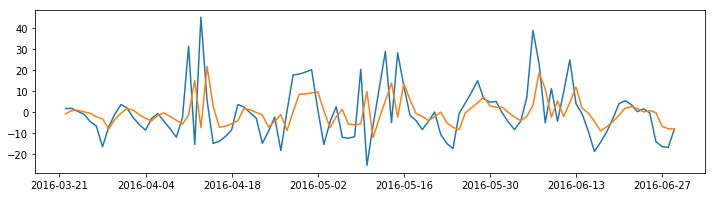

In [78]:
plt.figure(figsize=(12,3))
plt.plot(ts_stat[-100:])
plt.plot(model_fit.fittedvalues[-100:])

### Forecasting month of july 2016

In [79]:
#Add extra day since I removed the last cloudy day from the data
forecast,stderr,conf_int = model_fit.forecast(steps = 32) 

In [80]:
ts['date'].iloc[-1] #last day to do forecast from

Timestamp('2016-06-29 00:00:00')

In [81]:
date_forecast = pd.date_range('2016-06-30', periods=32)

In [82]:
forecast = pd.Series(data=forecast, index=date_forecast)
stderr = pd.Series(data=stderr, index=date_forecast)

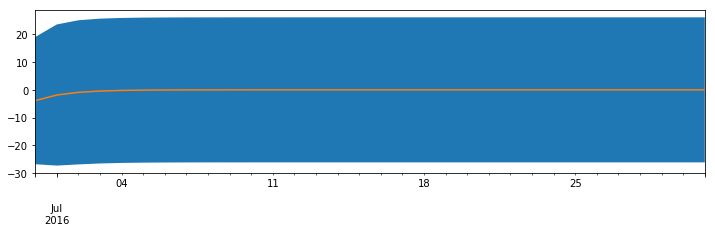

In [83]:
#Orange is forecast, blue 95% confidence interval
plt.figure(figsize=(12,3))
forecast.plot()
plt.fill_between(x=forecast.index, y1=forecast.values-1.96*stderr.values, y2=forecast.values+1.96*stderr.values) 
forecast.plot()

## Add the month and day effect

In [84]:
forecast.index

DatetimeIndex(['2016-06-30', '2016-07-01', '2016-07-02', '2016-07-03',
               '2016-07-04', '2016-07-05', '2016-07-06', '2016-07-07',
               '2016-07-08', '2016-07-09', '2016-07-10', '2016-07-11',
               '2016-07-12', '2016-07-13', '2016-07-14', '2016-07-15',
               '2016-07-16', '2016-07-17', '2016-07-18', '2016-07-19',
               '2016-07-20', '2016-07-21', '2016-07-22', '2016-07-23',
               '2016-07-24', '2016-07-25', '2016-07-26', '2016-07-27',
               '2016-07-28', '2016-07-29', '2016-07-30', '2016-07-31'],
              dtype='datetime64[ns]', freq='D')

In [85]:
#create a dataframe for the predictions
df_forecast = pd.DataFrame(data=forecast.values, index=forecast.index,columns=['Forecast'])

In [86]:
#month of july
df_forecast['Forecast_M'] = df_forecast['Forecast']+month_mean[7]

In [87]:
df_forecast.head()

,Forecast,Forecast_M
2016-06-30,-3.874146,-7.285400
2016-07-01,-1.863018,-5.274272
2016-07-02,-0.896464,-4.307719
2016-07-03,-0.431936,-3.843191
2016-07-04,-0.208683,-3.619937


In [88]:
df_forecast['dayOfWeek'] = df_forecast.index.map(lambda x: x.weekday)

In [89]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

def week_season_func_back(row):
    return row['Forecast_M']+week_day_mean[dayOfWeek[row['dayOfWeek']]]

df_forecast['Forecast_M_D'] = df_forecast.apply(week_season_func_back, axis=1)

In [90]:
df_forecast.head()

,Forecast,Forecast_M,dayOfWeek,Forecast_M_D
2016-06-30,-3.874146,-7.285400,3,-7.866303
2016-07-01,-1.863018,-5.274272,4,-4.246775
2016-07-02,-0.896464,-4.307719,5,-2.263801
2016-07-03,-0.431936,-3.843191,6,-2.116178
2016-07-04,-0.208683,-3.619937,0,-3.028259


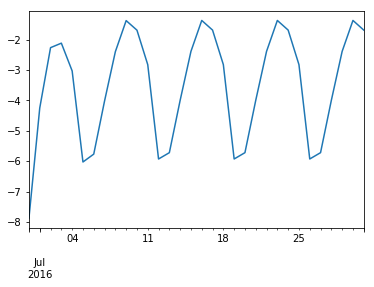

In [91]:
df_forecast['Forecast_M_D'].plot()

## Add the trend

In [92]:
#Add an extra day for july since I removed the cloudy last day of the data set
xdata_fore = np.arange(0,len(ts_cc_clear_inter+32))

In [93]:
background_trend_ext = func(xdata_fore, *popt)

In [94]:
df_forecast['Forecast_M_D_T'] = df_forecast['Forecast_M_D'] + background_trend_ext[-32:]

In [95]:
forecast_m_d_t = df_forecast['Forecast_M_D_T']

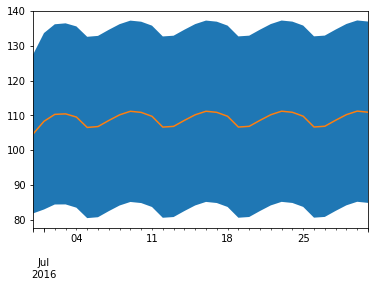

In [96]:
forecast_m_d_t.plot()
plt.fill_between(x=forecast.index, y1=forecast_m_d_t.values-1.96*stderr.values, 
                 y2=forecast_m_d_t.values+1.96*stderr.values) 
forecast_m_d_t.plot()

In [97]:
df_forecast.groupby('dayOfWeek').describe()['Forecast_M_D_T']

,count,mean,std,min,25%,50%,75%,max
dayOfWeek,,,,,,,,
0,4.0,109.714630,0.110973,109.549103,109.704757,109.762145,109.772018,109.785125
1,4.0,106.642176,0.059207,106.555328,106.631798,106.663023,106.673401,106.687332
2,4.0,106.864352,0.035764,106.814466,106.853303,106.872378,106.883427,106.898185
3,5.0,107.817160,1.735313,104.713200,108.560177,108.588409,108.601617,108.622399
4,5.0,109.831591,0.838547,108.331963,110.180799,110.198278,110.212513,110.234400
5,5.0,111.044038,0.408367,110.314325,111.203410,111.216286,111.231586,111.254582
6,5.0,110.822312,0.202642,110.461489,110.889877,110.901108,110.917491,110.941596


### Observation
-Saturday and Tuesday is correctly predicted to have the most and least amount of cars
Note: this was not the case when I used a sinusoidal function to remove the weekly effect, which is why I reiterated 
    and removed the mean instead. 

# Requested forecast of July (orange), blue 95% confidence interval

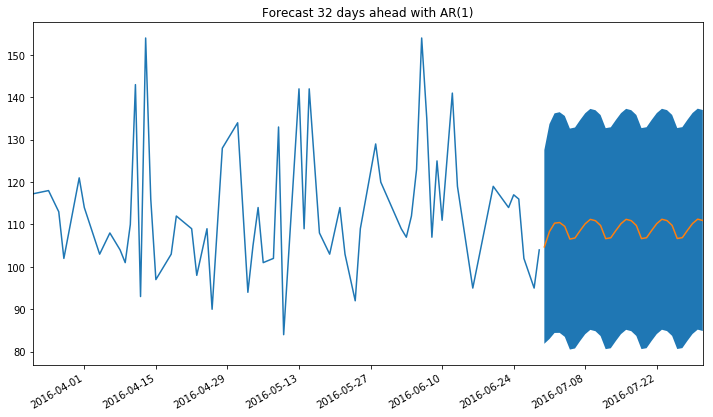

In [98]:
plt.figure(figsize=(12,7))

plt.plot(ts_cc_clear_inter.iloc[-100:])
plt.fill_between(x=forecast.index, y1=forecast_m_d_t.values-1.96*stderr.values, 
                 y2=forecast_m_d_t.values+1.96*stderr.values) 
forecast_m_d_t.plot()
plt.title('Forecast 32 days ahead with AR(1)');

# Summary

- The data used for the forecast was the previous 5 years of car counts after the trend and seasonal effects had been removed. A 3d order poynomial was fitted to be the background trend. Weekly and monthly mean was subtracted from the car counts. This so the time series would be stationary before fitting the data to a AR(1) process. 

- The AR(1) process would probably give an ok estimate for the first 5-7 days. However, as we can see in the past (training data), there is a lot more variation in the data that seem to be lost within the forecast. Since the AR(1) process is basically just anchored to its last value, it does not have much support for future predictions as we accumulate uncertainty in the predicted data with time. Perhaps a different model then AR(1) could do better, but that is for future discovery. 

Some things that could possibly improve the model: 
- Look at the images for days that have most cars (possible outliers) to see if this is an accurate estimate or not. Try removing them and see if the forecast seem to be more reasonable.  
- Make a better prediction of cloudy days data, might be able to remove the trend and then use which month and day it was to predict the cloudy days data. 
- I could also have looked at the seasonal effects within the months, considering everyone gets paid about the same time. Expect more cars straight after payday. 

Question that if answered might improve the model: 
- How is the car counts accouired? Are they a snap shot in time or accumulation throughout the day. Accumulation throughout the day would probably give a more fair estimate. 
